In [ ]:
!pip install transformers

In [ ]:
# prob won't need all these but this is just my copy paste
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from tqdm import tqdm, trange, tnrange
import random
import os
import io

In [ ]:
# check GPU on
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [ ]:
# seed everything for determinism
SEED = 47

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FairyTalesData(1).csv to FairyTalesData(1).csv
Saving garbas.csv to garbas.csv


In [ ]:
fairy_df = pd.read_csv('FairyTalesData(1).csv')
mixed_df = pd.read_csv('garbas.csv')

In [ ]:
print(len(fairy_df))
fairy_df.head()
fairy_df['Emotion'].value_counts()

14165


neutral      9307
happy        1919
anger        1110
fear          990
sad           529
surprised     310
Name: Emotion, dtype: int64

In [ ]:
print(len(mixed_df))
mixed_df.head()
mixed_df['Emotion'].value_counts()

11328


joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64

In [ ]:
# unbalanced fairytales
 	
from sklearn.utils import resample
# Divide by class
df_class_neutral = fairy_df[fairy_df['Emotion'] == 'neutral']
df_class_neutral.head()
df_class_neutral_under = resample(df_class_neutral,
                                  replace = False,
                                  n_samples = 1919,
                                  random_state=47)
df_class_neutral_under.info()
print(df_class_neutral_under.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1919 entries, 4982 to 8149
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  1919 non-null   object
 1   Text     1919 non-null   object
dtypes: object(2)
memory usage: 45.0+ KB
       Emotion                                               Text
4982   neutral  Puggie had died in the morning, and was to be ...
127    neutral   But Nutkin ran in front laughing, and shouting--
12377  neutral  When they came to the village, the son followe...
1298   neutral  Mr. McGregor caught sight of him at the corner...
1358   neutral  To 2 1/2 oz. conversation sweeties at three fa...


In [ ]:
fairy_df = fairy_df[fairy_df.Emotion != 'neutral']
fairy_df = pd.concat([fairy_df, df_class_neutral_under])

In [ ]:
fairy_df = fairy_df[fairy_df.Emotion != 'surprised']
fairy_df['Emotion'].value_counts()

happy      1919
neutral    1919
anger      1110
fear        990
sad         529
Name: Emotion, dtype: int64

In [ ]:
frames = [mixed_df, fairy_df]
df = pd.concat(frames)
df.head()
print(len(df))

17795


In [ ]:
df.tail()

,Emotion,Text
8151,neutral,As a little boy he had seen all these fine doi...
4519,neutral,A more fantastical imagination than Herschel's...
12153,neutral,"I will not be king."""
5167,neutral,"She was the boatman's daughter, graceful and d..."
8149,neutral,The sun shone; and although they had a little ...


In [ ]:
df['Emotion'].value_counts()

neutral    4173
anger      3369
fear       3161
joy        2326
sadness    2317
happy      1919
sad         529
Name: Emotion, dtype: int64

In [ ]:
df = df.replace('sadness', 'sad')
df = df.replace('happy', 'joy')
df['Emotion'].value_counts()

joy        4245
neutral    4173
anger      3369
fear       3161
sad        2846
Name: Emotion, dtype: int64

In [ ]:
df_neutral = df[df['Emotion'] == 'neutral']
df_joy = df[df['Emotion'] == 'joy']
df_anger = df[df['Emotion'] == 'anger']
df_fear = df[df['Emotion'] == 'fear']
df_sad = df[df['Emotion'] == 'sad']

df_neutral_under = resample(df_neutral,
                                  replace = False,
                                  n_samples = 3500,
                                  random_state=47)
df_joy_under = resample(df_joy,
                                  replace = False,
                                  n_samples = 3500,
                                  random_state=47)
df_anger_over = resample(df_anger,
                                  replace = True,
                                  n_samples = 3500,
                                  random_state=47)
df_fear_over = resample(df_fear,
                                  replace = True,
                                  n_samples = 3500,
                                  random_state=47)
df_sad_over = resample(df_sad,
                                  replace = True,
                                  n_samples = 3500,
                                  random_state=47)

In [ ]:
df_balanced = pd.concat([df_neutral_under, 
                         df_joy_under, 
                         df_anger_over, 
                         df_fear_over, 
                         df_sad_over])

In [ ]:
df_balanced.head()

,Emotion,Text
3969,neutral,My father told us that the child's parents had...
11142,neutral,There was once upon a time a king who had a gr...
348,neutral,Haven't you heard that he is in prison ?
6516,neutral,"Several of the neighbors came in, and amongst ..."
8390,neutral,Let the thing sit there and enjoy its life.


In [ ]:
df_balanced['Emotion'].value_counts()

sad        3500
fear       3500
joy        3500
anger      3500
neutral    3500
Name: Emotion, dtype: int64

In [ ]:
df_balanced = df_balanced.sample(frac=1)

In [ ]:
df_balanced.head()

,Emotion,Text
4453,fear,But experts at the Coney Hill Psychiatric Hosp...
5608,anger,I never went to court .
457,sad,Power cut made me unable to listen to the song...
5927,neutral,I see .
5347,anger,When I found out my cousin had been killed. I ...


In [ ]:
df_balanced.to_csv('FairyGarbas.csv')

In [ ]:
# encode labels
# using one hot encodings so neural net can process
labelencoder = LabelEncoder()
df_balanced['label_enc'] = labelencoder.fit_transform(df_balanced['Emotion'])
df_balanced[['Emotion','label_enc']].drop_duplicates(keep='first')
print(df_balanced.head())

# check the distributions with our newly encoded labels
print('Distribution: ', df_balanced.label_enc.value_counts())

      Emotion                                               Text  label_enc
4453     fear  But experts at the Coney Hill Psychiatric Hosp...          1
5608    anger                           I never went to court .           0
457       sad  Power cut made me unable to listen to the song...          4
5927  neutral                                           I see .           3
5347    anger  When I found out my cousin had been killed. I ...          0
Distribution:  4    3500
3    3500
2    3500
1    3500
0    3500
Name: label_enc, dtype: int64


In [ ]:
labels = df_balanced.drop_duplicates('Emotion').set_index('label_enc').drop(['Text'],axis=1)

In [ ]:
label_dict = labels.to_dict()['Emotion']
label_dict = {value:key for key, value in label_dict.items()}
print(label_dict)

{'fear': 1, 'anger': 0, 'sad': 4, 'neutral': 3, 'joy': 2}


In [ ]:
# split the dataset early: we do this cause I found a neat thing
X_train, X_val, y_train, y_val = train_test_split(df_balanced.Text.values, 
                                                  df_balanced.label_enc.values, 
                                                  test_size=0.15, 
                                                  random_state=47, 
                                                  stratify=df_balanced.label_enc.values)

# check the training and validation sets for some sanity
print(X_train[0])
print(X_val[0])

 Come on ! A little labor , much health . 
The fourth, "Who has been meddling with my spoon?"


In [ ]:
# import the Bert tokenizer (we need this so we can get all the special characters)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
# I don't set the max length super long as these are just short tweets
# This will vary for your own data
MAX_LENGTH = 300

# tokenize with bert
'''
bert tokenizer can also make an attention mask for your data!
it can also format everything as torch tensors! we can skip steps now.
However, because of how it works, we do train-test-split early so we can 
generate masks for both sets
'''                                   
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_LENGTH, 
    truncation = True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=MAX_LENGTH, 
    truncation = True,
    return_tensors='pt'
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# the return from our tokenizer was a dict (i think)
# the word embeddings and attention mask are all contained in the dict and we set them
# make all the train embeddings, masks, labels + test embeddings, masks, labels
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)
print("training size: ", len(input_ids_train))

# do the same with validation
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)
print("val size: ", len(input_ids_val))

# putting stuff into pytorch format
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

training size:  14875
val size:  2625


In [ ]:
# now we load in our bert model with the correct number of labels (5)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# set the batch size
batch_size = 32

# set up the pytorch dataloaders
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
# set our optimizer
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  eps=1e-8)
# set our epochs             
epochs = 5

# set our scheduler
'''
PyTorch Scheduler:
What is a learning rate scheduler?
It is useful to reduce learning rate as the model trains since it is getting "smarter"
and we don't want to mess with it as much. The learning rate scheduler gives a
predefined schedule for how the learning rate changes. Similar to loss functions,
there are multiple scheduler functions. Here, we use linear. 
We didn't use one in the CNN demo for simplicity sake.
The learning rate scheduler works once per epoch. We don't want it to update once
per batch like the optimizer or it goes too crazy
'''
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# build our evaluation scheme
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        # logits
        '''
        Logits are the unnormalized predictions of the model, we operate on them
        so that they go from raw data to something useful
        '''
        logits = outputs[1]
        loss_val_total += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    

In [ ]:
# we need to train everything on one device (either CPU or GPU)
# If you cross streams PyTorch gets mad
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(device)

cuda


In [ ]:
# these are metrics for our validation and testing
# more on this stuff: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
# fine-tuning loop
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    # a progress bar for prettier progress
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        position = 0, 
                        leave=True, 
                        disable=False)
    
    for batch in progress_bar:

        # zero the gradients
        model.zero_grad()
        
        # send stuff to GPU
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        # get some outputs
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        # clip gradients to avoid explosion
        # more on this: https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # step the optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
        # format the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    # here I save the model at each epoch. This is so that maybe if epoch 3 is the best we still have it lying around
    # BE SURE TO DOWNLOAD YOUR SAVED MODELS BEFORE CLOSING YOUR KERNEL OR COLAB WILL KILL THEM :(
    torch.save(model.state_dict(), f'finetuned_BERT_FairyGarb_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    # get the evaluation info
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

'''
Notice how we have not actually trained a full model (there is no 'forward'
function like we made in the CNN demo) 
We are just fine-tuning the output layers of BERT
BERT is very general, so by tuning it to a downstream task (emotional analysis
in our case) we can get pretty decent results
'''


  0%|          | 0/5 [12:27<?, ?it/s]


Epoch 1
Training loss: 0.9086552860916302


Epoch 2:   0%|          | 0/465 [00:00<?, ?it/s]

Validation loss: 0.6096242219209671
F1 Score (Weighted): 0.7805316437689274


 20%|██        | 1/5 [26:05<53:14, 798.60s/it]


Epoch 2
Training loss: 0.48192225944611333


Epoch 3:   0%|          | 0/465 [00:00<?, ?it/s]

Validation loss: 0.5395895895738918
F1 Score (Weighted): 0.8178792902030649


 40%|████      | 2/5 [39:41<40:12, 804.24s/it]


Epoch 3
Training loss: 0.28631410187771245


Epoch 4:   0%|          | 0/465 [00:00<?, ?it/s]

Validation loss: 0.5336142479812345
F1 Score (Weighted): 0.8358322130352339


 60%|██████    | 3/5 [53:20<26:55, 807.83s/it]


Epoch 4
Training loss: 0.17873934093181804


Epoch 5:   0%|          | 0/465 [00:00<?, ?it/s]

Validation loss: 0.5852585083199104
F1 Score (Weighted): 0.8344728760414645


 80%|████████  | 4/5 [1:07:02<13:31, 811.19s/it]


Epoch 5
Training loss: 0.12286937822417546


100%|██████████| 5/5 [1:07:52<00:00, 814.55s/it]

Validation loss: 0.6106990840207471
F1 Score (Weighted): 0.8350656087080743


"\nNotice how we have not actually trained a full model (there is no 'forward'\nfunction like we made in the CNN demo) \nWe are just fine-tuning the output layers of BERT\nBERT is very general, so by tuning it to a downstream task (emotional analysis\nin our case) we can get pretty decent results\n"

In [ ]:
# load the model and test it
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_FairyGarb_epoch_3.model', map_location=torch.device('cuda')))

_, predictions, true_vals = evaluate(dataloader_validation)
# check the per-class accuracy
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: anger
Accuracy: 453/525

Class: fear
Accuracy: 453/525

Class: joy
Accuracy: 416/525

Class: neutral
Accuracy: 404/525

Class: sad
Accuracy: 467/525



In [ ]:
def create_confusion_matrix(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  y_actu = pd.Series(labels_flat, name='Actual')
  y_pred = pd.Series(preds_flat, name='Predicted')

  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion

In [ ]:
conf_df = create_confusion_matrix(predictions,true_vals)
print(conf_df)

Predicted    0    1    2    3    4
Actual                            
0          453   17   12   26   17
1           18  453   12   27   15
2            7   12  416   78   12
3           27   19   60  404   15
4           20   12   10   16  467


In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrixdf(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

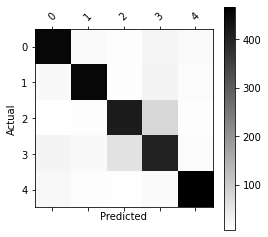

In [ ]:
plot_confusion_matrixdf(create_confusion_matrix(predictions, true_vals))
# neutral and joy
